<a href="https://colab.research.google.com/github/dokunoale/chagas/blob/colloquio/notebooks/Simple_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone -b dev https://github.com/dokunoale/chagas.git
!pip install -r chagas/requirements.txt

# Download the dataset
import gdown

url = "https://drive.google.com/file/d/1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC/view?usp=drive_link"
gdown.download(url, "dataset.zip", quiet=False, fuzzy=True)
!unzip -q /content/dataset.zip -d chagas/data/


Cloning into 'chagas'...
remote: Enumerating objects: 538, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 538 (delta 49), reused 64 (delta 27), pack-reused 438 (from 1)
Receiving objects: 100% (538/538), 4.32 MiB | 17.49 MiB/s, done.
Resolving deltas: 100% (263/263), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 125.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 26.1 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.1
    Uninstalling joblib-1.5.1:
      Successfully uninstalled joblib-1.5.1
  Attempting uninstall: h5py
    Found existing installation: h5py 3.14.0
    Uninstalling h5py-3.14.0:
      Successfully uninstalled h5py-3.14.0
  Attempting uninstall: scikit-learn
 

Downloading...
From (original): https://drive.google.com/uc?id=1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC
From (redirected): https://drive.google.com/uc?id=1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC&confirm=t&uuid=8a88ee88-9ce4-4dfb-8506-4b09e4aa6db1
To: /content/dataset.zip
100%|██████████| 623M/623M [00:06<00:00, 93.1MB/s]


In [2]:
import sys
sys.path.append("/content/chagas/src")

import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import AUC

Caricamento del dataset e preprocessing.

In [3]:
from preprocessing.tf_dataset_loader import WfdbLoader
from preprocessing.filters import FiltfiltNoiseReducer

# Carichiamo il dataset
data_path = "/content/chagas/data/big_splitted_dataset/"

filter = FiltfiltNoiseReducer(fs=400, iir_freq=55.0, butterworth_cutoff=5., lowpass_cutoff=30., verbose=True)

train = WfdbLoader(label = 'Chagas label')
train.add_filter(filter)
train.add_filter(filter)
train.add_dataset(data_path + "train/positives")
train.add_dataset(data_path + "train/negatives")
X_train, y_train = train.load(shuffle=True, verbose=True)

validation = WfdbLoader(label = 'Chagas label')
validation.add_filter(filter)
validation.add_filter(filter)
validation.add_dataset(data_path + "val/positives")
validation.add_dataset(data_path + "val/negatives")
X_val, y_val = validation.load(shuffle=True, verbose=True)

test = WfdbLoader(label = 'Chagas label')
test.add_filter(filter)
test.add_filter(filter)
test.add_dataset(data_path + "test/positives")
test.add_dataset(data_path + "test/negatives")
X_test, y_test = test.load(shuffle=True, verbose=True)

y_test_info = test.get_metadata()

Filtering records - filtfilt: 100%|██████████| 2245/2245 [00:12<00:00, 173.39record/s]


# Training

In [6]:
def build_lstm_model(
    input_shape=(2800, 12),
    lstm_units=64,
    dropout_rate=0.3
):
    inputs = layers.Input(shape=input_shape, name='input_layer')  # (2800, 12)

    # Primo livello LSTM bidirezionale
    x = layers.Bidirectional(
        layers.LSTM(lstm_units, return_sequences=True, name='lstm_1'),
        name='bidirectional_lstm_1'
    )(inputs)
    x = layers.Dropout(dropout_rate, name='dropout_1')(x)

    # Secondo livello LSTM bidirezionale
    x = layers.Bidirectional(
        layers.LSTM(lstm_units, name='lstm_2'),
        name='bidirectional_lstm_2'
    )(x)
    x = layers.Dropout(dropout_rate, name='dropout_2')(x)

    # Dense layers
    x = layers.Dense(256, activation='relu', name='dense_1')(x)
    x = layers.Dropout(dropout_rate, name='dropout_3')(x)
    x = layers.Dense(64, activation='relu', name='dense_2')(x)

    # Output layer
    outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)

    model = models.Model(inputs, outputs, name='ECG_LSTM_Model')
    return model


# Compilazione del modello
model = build_lstm_model(input_shape=(2800, 12))
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

model.summary()

Model: "ECG_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2800, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_1            │ (None, 2800, 128)      │        39,424 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2800, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_2            │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,777 (733.50 KB)

 Trainable params: 187,777 (733.50 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Callback: early stopping e salvataggio del modello migliore
early_stop = EarlyStopping(monitor='val_auc', patience=6, min_delta=1e-3, mode='max', restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_auc', mode='max', save_best_only=True)

callbacks = [early_stop, checkpoint]

# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=30,
    callbacks=callbacks
)

Epoch 1/40
262/262 ━━━━━━━━━━━━━━━━━━━━ 90s 315ms/step - accuracy: 0.5206 - auc: 0.5319 - loss: 0.6918 - val_accuracy: 0.5089 - val_auc: 0.5760 - val_loss: 0.6904
Epoch 2/40
262/262 ━━━━━━━━━━━━━━━━━━━━ 82s 312ms/step - accuracy: 0.5388 - auc: 0.5590 - loss: 0.6874 - val_accuracy: 0.5508 - val_auc: 0.5834 - val_loss: 0.6852
Epoch 3/40
262/262 ━━━━━━━━━━━━━━━━━━━━ 82s 312ms/step - accuracy: 0.5415 - auc: 0.5655 - loss: 0.6873 - val_accuracy: 0.5152 - val_auc: 0.5899 - val_loss: 0.6879
Epoch 4/40
262/262 ━━━━━━━━━━━━━━━━━━━━ 82s 312ms/step - accuracy: 0.5181 - auc: 0.5317 - loss: 0.6919 - val_accuracy: 0.5053 - val_auc: 0.5236 - val_loss: 0.6920
Epoch 5/40
262/262 ━━━━━━━━━━━━━━━━━━━━ 82s 312ms/step - accuracy: 0.5175 - auc: 0.5160 - loss: 0.6928 - val_accuracy: 0.5214 - val_auc: 0.5276 - val_loss: 0.6911
Epoch 6/40
262/262 ━━━━━━━━━━━━━━━━━━━━ 82s 312ms/step - accuracy: 0.5432 - auc: 0.5468 - loss: 0.6888 - val_accuracy: 0.5009 - val_auc: 0.5365 - val_loss: 0.6927
Epoch 7/40
262/262 ━━━

Stampa un report che riassume il modello e le sue performance

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step
Optimal threshold: 0.511
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step


71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step


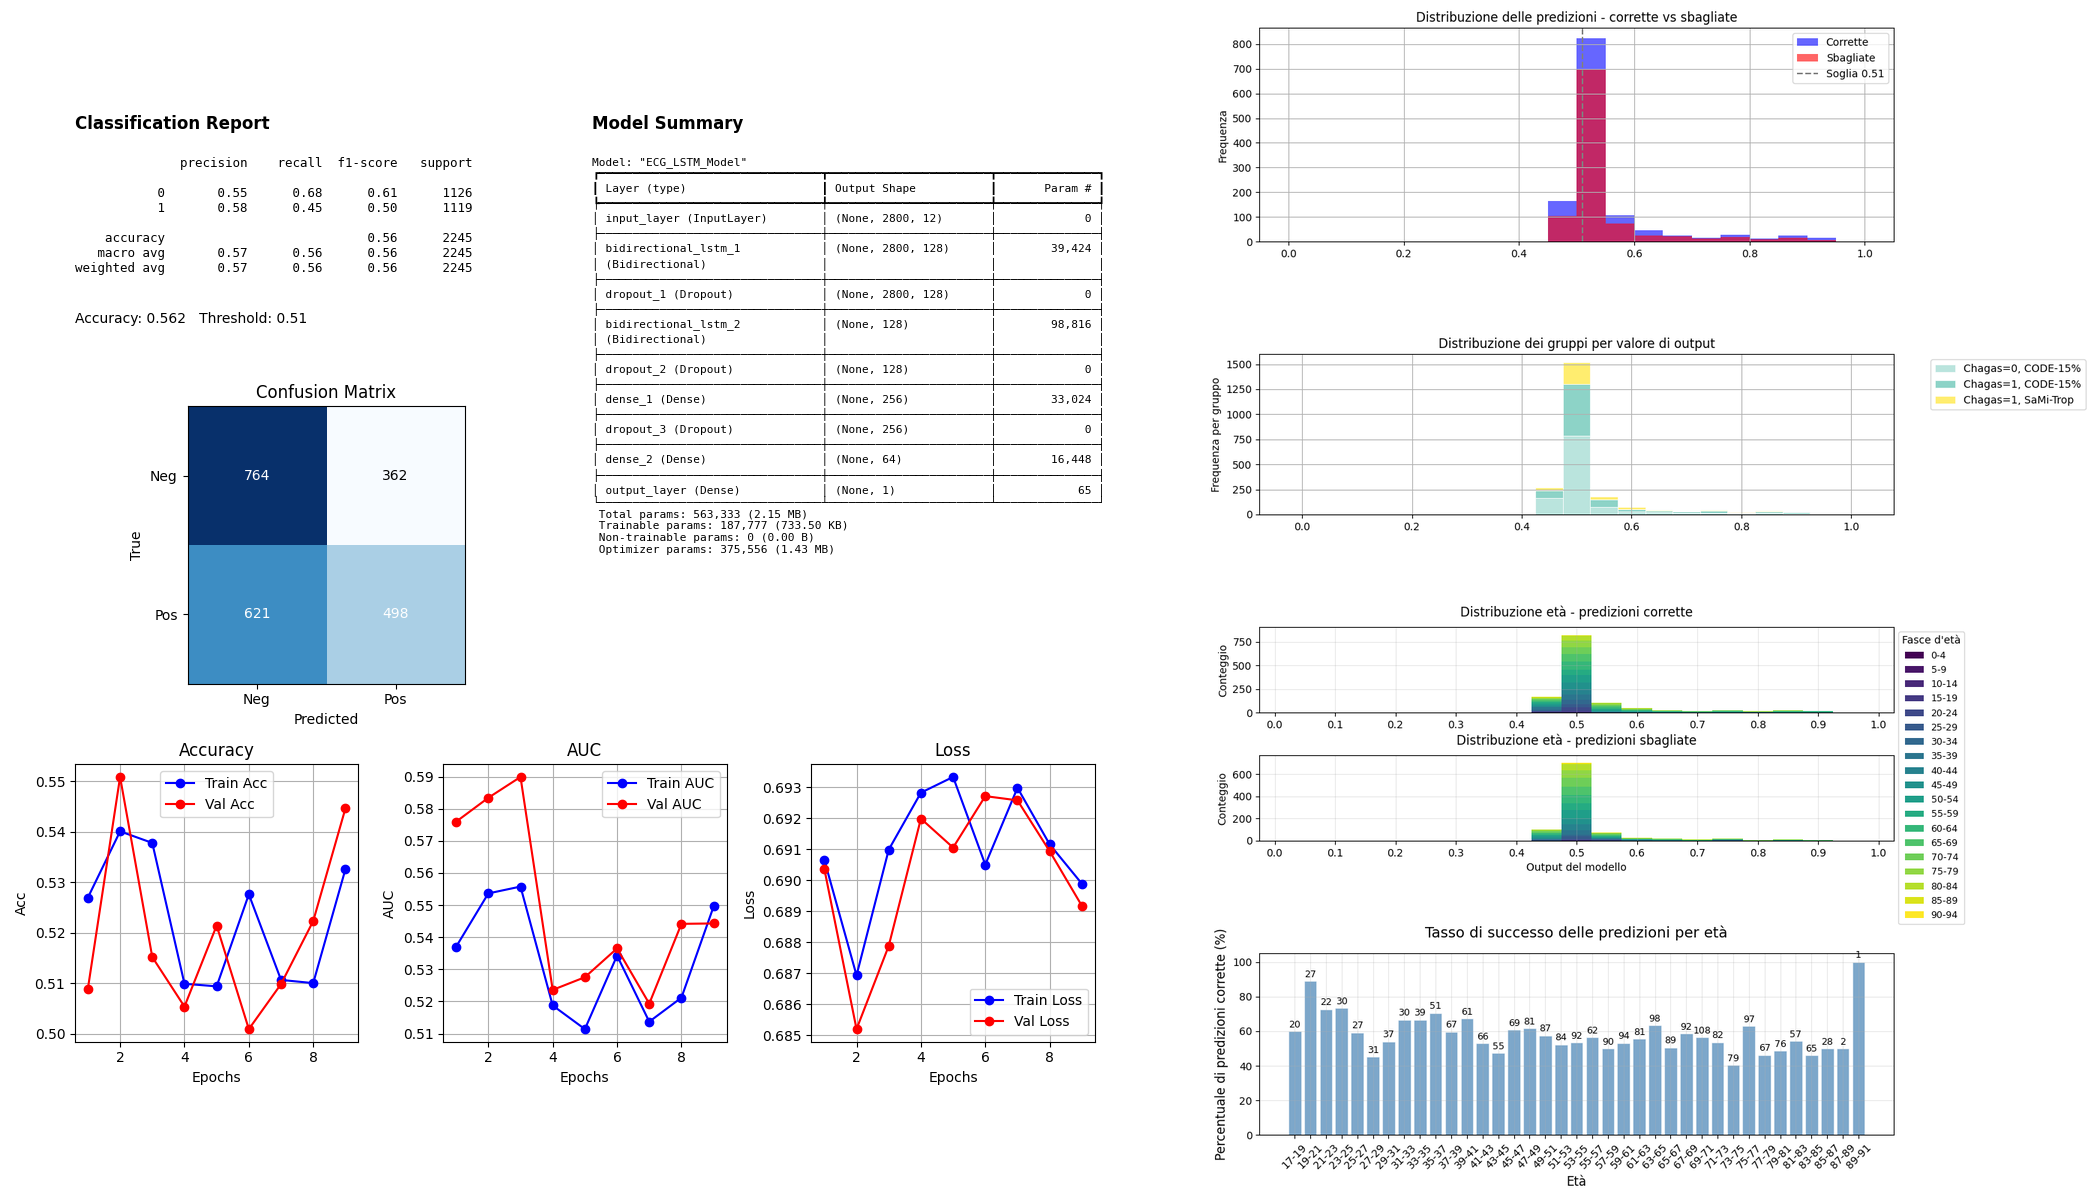

In [8]:
# NON MODIFICARE

from models.utils import find_optimal_threshold
from models.analysis import plot_full_report_and_metrics, plot_model_analysis
from PIL import Image

y_pred_probs = model.predict(X_val)
threshold = find_optimal_threshold(y_val, y_pred_probs)

img1 = plot_full_report_and_metrics(model, X_test, y_test, history, threshold, return_pillow=True)
img2 = plot_model_analysis(model, X_test, y_test, y_test_info, threshold, return_pillow=True)

# 1. Ridimensiona img2 all'altezza di img1, mantenendo le proporzioni
new_height = int(img1.height * 1.2)
new_width = int(img2.width * (new_height / img2.height))
img2_resized = img2.resize((new_width, new_height), Image.LANCZOS)

# 2. Calcola la nuova immagine
total_width = img1.width + img2_resized.width
max_height = max(img1.height, img2_resized.height)
new_img = Image.new('RGB', (total_width, max_height), color=(255, 255, 255))

# 3. Centra verticalmente img1 (se img1 è più bassa di max_height)
y_offset_img1 = (max_height - img1.height) // 2
y_offset_img2 = (max_height - img2_resized.height) // 2

new_img.paste(img1, (0, y_offset_img1))
new_img.paste(img2_resized, (img1.width, y_offset_img2))

# 4. Visualizza nel notebook
display(new_img)